In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Image transformations (Resize and Normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 64x64
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB for compatibility with model input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


In [4]:
# Custom dataset for loading the images
class CUFS_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [5]:
# Load dataset
dataset_path = '/kaggle/input/cuhk-face-sketch-database-cufs/cropped_sketch'
dataset = CUFS_Dataset(root_dir=dataset_path, transform=transform)

# DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


In [6]:
# Define Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 3 * 64 * 64)

        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(1024)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.relu(self.batchnorm1(self.fc1(z)))
        z = self.relu(self.batchnorm2(self.fc2(z)))
        z = self.relu(self.batchnorm3(self.fc3(z)))
        z = self.fc4(z)
        z = z.view(-1, 3, 64, 64)
        return self.tanh(z)


In [7]:
# Define Critic (Discriminator) network
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.fc1 = nn.Linear(512 * 4 * 4, 1)

        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.leakyrelu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [8]:
# Initialize models
generator = Generator().to(device)
critic = Critic().to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_c = optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lambda for gradient penalty
lambda_gp = 10


In [9]:
# Function to compute gradient penalty
def compute_gradient_penalty(critic, real_images, fake_images):
    batch_size = real_images.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = alpha * real_images + (1 - alpha) * fake_images
    interpolated_images.requires_grad_(True)

    d_interpolated = critic(interpolated_images)
    gradients = torch.autograd.grad(
        outputs=d_interpolated, inputs=interpolated_images,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # L2 norm
    return gradient_penalty


In [10]:
# Function to visualize images
def show_images(real_images, fake_images, epoch):
    real_images = real_images.detach().cpu()
    fake_images = fake_images.detach().cpu()
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(make_grid(real_images, nrow=8).permute(1, 2, 0))
    ax[0].set_title("Real Images")
    ax[0].axis('off')
    
    ax[1].imshow(make_grid(fake_images, nrow=8).permute(1, 2, 0))
    ax[1].set_title(f"Generated Images (Epoch {epoch})")
    ax[1].axis('off')
    
    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], Critic Loss: -58.2189, Generator Loss: 66.2708
Epoch [2/50], Critic Loss: -45.0851, Generator Loss: 37.0839
Epoch [3/50], Critic Loss: -46.2910, Generator Loss: 77.5226
Epoch [4/50], Critic Loss: -40.8550, Generator Loss: 90.7469
Epoch [5/50], Critic Loss: -44.1757, Generator Loss: 68.8050
Epoch [6/50], Critic Loss: -36.1796, Generator Loss: 67.0605
Epoch [7/50], Critic Loss: -31.1273, Generator Loss: 74.5439
Epoch [8/50], Critic Loss: -31.6843, Generator Loss: 57.1962
Epoch [9/50], Critic Loss: -30.3299, Generator Loss: 59.7586
Epoch [10/50], Critic Loss: -28.8796, Generator Loss: 57.1363


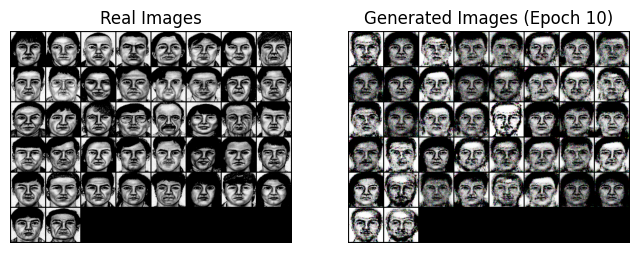

Epoch [11/50], Critic Loss: -26.6098, Generator Loss: 58.5203
Epoch [12/50], Critic Loss: -24.3825, Generator Loss: 53.8985
Epoch [13/50], Critic Loss: -21.6583, Generator Loss: 58.0170
Epoch [14/50], Critic Loss: -21.3039, Generator Loss: 44.9754
Epoch [15/50], Critic Loss: -21.0182, Generator Loss: 48.4563
Epoch [16/50], Critic Loss: -20.5704, Generator Loss: 47.2666
Epoch [17/50], Critic Loss: -26.0545, Generator Loss: 44.3474
Epoch [18/50], Critic Loss: -21.5053, Generator Loss: 39.5548
Epoch [19/50], Critic Loss: -19.6825, Generator Loss: 41.2622
Epoch [20/50], Critic Loss: -25.4366, Generator Loss: 46.9894


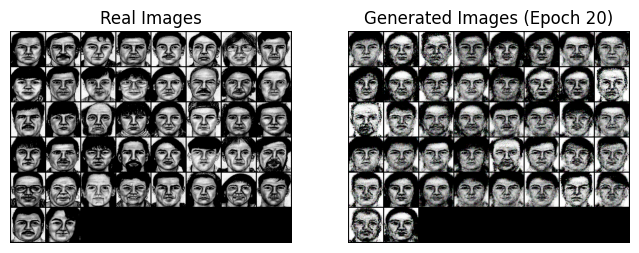

Epoch [21/50], Critic Loss: -23.3951, Generator Loss: 33.2424
Epoch [22/50], Critic Loss: -20.9594, Generator Loss: 38.7039
Epoch [23/50], Critic Loss: -19.1097, Generator Loss: 40.8012
Epoch [24/50], Critic Loss: -20.7580, Generator Loss: 40.0865
Epoch [25/50], Critic Loss: -21.6637, Generator Loss: 34.0632
Epoch [26/50], Critic Loss: -19.3258, Generator Loss: 43.2838
Epoch [27/50], Critic Loss: -20.5187, Generator Loss: 44.5721
Epoch [28/50], Critic Loss: -21.1101, Generator Loss: 29.9922
Epoch [29/50], Critic Loss: -19.7839, Generator Loss: 41.8400
Epoch [30/50], Critic Loss: -18.6237, Generator Loss: 36.7786


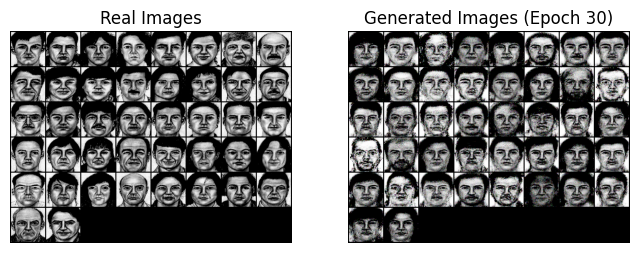

Epoch [31/50], Critic Loss: -18.0614, Generator Loss: 39.1020
Epoch [32/50], Critic Loss: -19.0145, Generator Loss: 31.9340
Epoch [33/50], Critic Loss: -19.0671, Generator Loss: 28.1625
Epoch [34/50], Critic Loss: -19.1503, Generator Loss: 23.4420
Epoch [35/50], Critic Loss: -21.1616, Generator Loss: 34.6462
Epoch [36/50], Critic Loss: -17.9093, Generator Loss: 29.1179
Epoch [37/50], Critic Loss: -19.0494, Generator Loss: 30.1224
Epoch [38/50], Critic Loss: -20.5950, Generator Loss: 28.4520
Epoch [39/50], Critic Loss: -19.1959, Generator Loss: 19.0050
Epoch [40/50], Critic Loss: -21.2744, Generator Loss: 20.4347


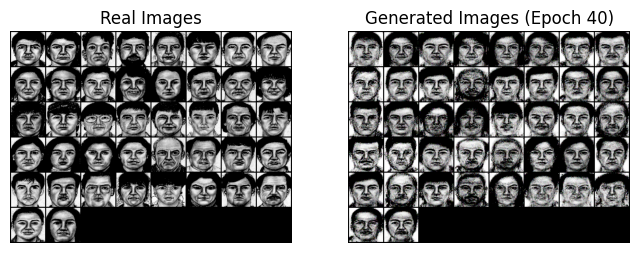

Epoch [41/50], Critic Loss: -18.9528, Generator Loss: 23.7307
Epoch [42/50], Critic Loss: -20.7282, Generator Loss: 27.1408
Epoch [43/50], Critic Loss: -19.4456, Generator Loss: 24.1766
Epoch [44/50], Critic Loss: -19.5090, Generator Loss: 19.4801
Epoch [45/50], Critic Loss: -19.8319, Generator Loss: 25.1213
Epoch [46/50], Critic Loss: -21.5158, Generator Loss: 31.3221
Epoch [47/50], Critic Loss: -19.9796, Generator Loss: 25.8305
Epoch [48/50], Critic Loss: -18.7130, Generator Loss: 33.5524
Epoch [49/50], Critic Loss: -19.4269, Generator Loss: 28.3352
Epoch [50/50], Critic Loss: -18.8390, Generator Loss: 32.0489


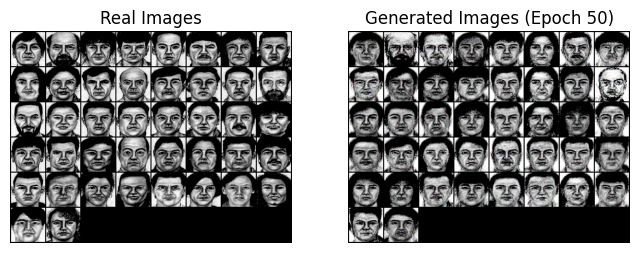

In [11]:

# Training loop
num_epochs = 50
critic_losses = []
generator_losses = []

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Critic (Discriminator) - 5 iterations per generator update
        for _ in range(5):
            optimizer_c.zero_grad()
            
            # Real images
            real_output = critic(real_images)
            d_real_loss = real_output.mean()

            # Fake images
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise)
            fake_output = critic(fake_images.detach())  # Detach to avoid backprop through generator
            d_fake_loss = fake_output.mean()

            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images)

            # Total critic loss
            d_loss = d_fake_loss - d_real_loss + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_c.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_images = generator(noise)  # Regenerate fake images for the generator step
        fake_output = critic(fake_images)
        g_loss = -fake_output.mean()  # Minimize the negative of the critic's output
        g_loss.backward(retain_graph=True)  # Retain graph to compute further backward passes

        optimizer_g.step()

        # Record losses
        critic_losses.append(d_loss.item())
        generator_losses.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Critic Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
    
    # Show images and loss plot
    if (epoch+1) % 10 == 0:
        show_images(real_images, fake_images, epoch+1)



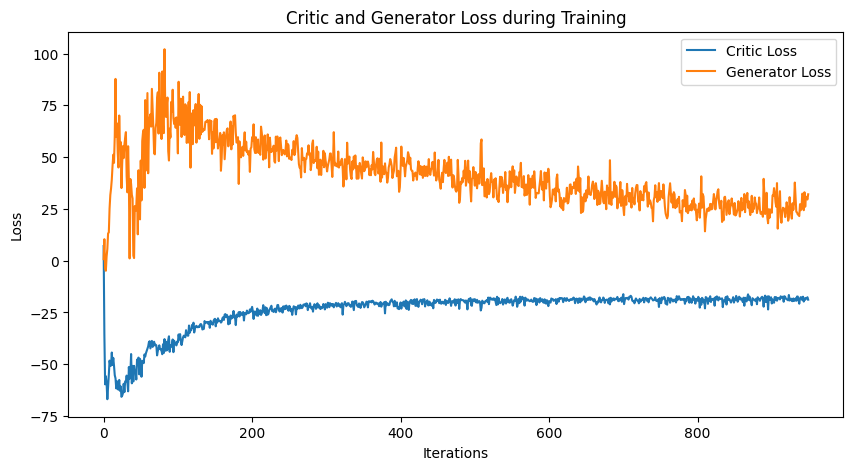

In [12]:
# Plot the losses (Critic and Generator)
plt.figure(figsize=(10,5))
plt.plot(critic_losses, label='Critic Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Critic and Generator Loss during Training')
plt.show()


In [13]:
torch.save(generator.state_dict(), 'WGAN_generator_weights.pth')
torch.save(critic.state_dict(), 'Critic_weights.pth')


In [14]:
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms
import torch
from torch.utils.data import DataLoader

# Load InceptionV3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights).to(device)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize((0.5,), (0.5,))
])

def preprocess_images(images):
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)  # Grayscale to RGB
    return torch.stack([transform(img.cpu()) for img in images])

def get_activations(images, model, batch_size=32, dims=2048):
    dataloader = DataLoader(images, batch_size=batch_size)
    pred_arr = np.empty((len(images), dims))
    start_idx = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            pred = model(batch).view(batch.size(0), -1)
            pred_arr[start_idx:start_idx + batch.size(0)] = pred.cpu().numpy()
            start_idx += batch.size(0)

    return pred_arr

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Make sure your variables are named `test_images` and `generated_images`
real_images = real_images.to(device)
fake_images = fake_images.to(device)

real_images = preprocess_images(real_images)
fake_images = preprocess_images(fake_images)

# Calculate activations and FID
act1 = get_activations(real_images, inception)
act2 = get_activations(fake_images, inception)

fid_score = calculate_fid(act1, act2)
print("FID Score:", fid_score)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 212MB/s] 


FID Score: 92.93984915579543
